# Home Credit Default Risk

This kernel will contain EDA, visualization, feature engineering and some modelling. Work currently in progress.

In [1]:
import numpy as np    # 기본 모듈
import pandas as pd
import os
from scipy import stats
from scipy.sparse import hstack, csr_matrix

import seaborn as sns  # 시각화
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('max_columns', 150)

import datetime

from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

import xgboost as xgb
import lightgbm as lgb

from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams

There are several files with data. Let's go through them step by step.

In [2]:
folder =  '../input/'

application_train = pd.read_csv(os.path.join(folder, 'application_train.csv'))
application_test = pd.read_csv(os.path.join(folder, 'application_test.csv'))
bureau = pd.read_csv(os.path.join(folder, 'bureau.csv'))
bureau_balance = pd.read_csv(os.path.join(folder, 'bureau_balance.csv'))
POS_CASH_balance = pd.read_csv(os.path.join(folder, 'POS_CASH_balance.csv'))
credit_card_balance = pd.read_csv(os.path.join(folder, 'credit_card_balance.csv'))
previous_application = pd.read_csv(os.path.join(folder, 'previous_application.csv'))
installments_payments = pd.read_csv(os.path.join(folder, 'installments_payments.csv'))
sample_submission = pd.read_csv(os.path.join(folder, 'sample_submission.csv'))

## Data Exploration

### application_train and application_test
These are main files with data and technically we can use only them to make predictions. Obviously using additional data is necessary to improve score.

In [7]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,app AMT_CREDIT / AMT_ANNUITY,app EXT_SOURCE mean,app EXT_SOURCE_1 / DAYS_BIRTH,app AMT_INCOME_TOTAL / 12- AMT_ANNUITY,app AMT_INCOME_TOTAL / AMT_ANNUITY,app AMT_INCOME_TOTAL - AMT_GOODS_PRICE
0,100002,1,Cash loans,M,N,Y,0,1.275814,1.290061,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,0.0,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.000052,0.161787,-0.000009,-24700.393682,0.000052,-3.509987e+05
1,100003,0,Cash loans,F,N,N,0,1.281808,1.311812,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,0.0,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000037,0.466757,-0.000019,-35698.393183,0.000036,-1.129499e+06
2,100004,0,Revolving loans,M,Y,Y,0,1.251290,1.267078,6750.0,135000.0,Unaccompanied,Wo

We have 122 columns in just main file! Let's take a look on some of them.

#### Categorical features

##### Target

In [8]:
application_train.TARGET.value_counts(normalize=True)
# application_train['TARGET'].value_counts(normalize=False)
# column 호출을 함수처럼 할 수 있고, normalize=True로 하면 비율을 보여줌.

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

We have disbalanced target(역시나), though disbalance isn't really serious.(왜?)

##### NAME_CONTRACT_TYPE

In [9]:
pd.crosstab(application_train.TARGET, application_train.NAME_CONTRACT_TYPE, dropna=False, normalize='all')

NAME_CONTRACT_TYPE,Cash loans,Revolving loans
TARGET,,
0,0.829274,0.089997
1,0.075513,0.005216


We can see that therer are two types of contract - cash loans and revolving loans. Most of the loans are cash loans which are defaulted.

##### CODE_GENDER

In [10]:
pd.crosstab(application_train.TARGET, application_train.CODE_GENDER, dropna=False, normalize='all')

CODE_GENDER,F,M,XNA
TARGET,,,
0,0.612264,0.306994,0.000013
1,0.046080,0.034649,0.000000


We can see that women take more loans and higher percentage of them repays the loans. And there are 4 people with unidentified gender, who repayed their loans.

##### FLAG_OWN_CAR and FLAG_OWN_REALTY

In [11]:
print('There are {0} people with realty. {1}% of them repay loans.'. format(application_train[application_train.FLAG_OWN_REALTY == 'Y'].shape[0], np.round(application_train[application_train.FLAG_OWN_REALTY == 'Y'].TARGET.value_counts(normalize=True).values[1], 3) * 100))
print('There are {0} people with cars. {1}% of them repay loans.'.format(application_train[application_train.FLAG_OWN_CAR == 'Y'].shape[0], np.round(application_train[application_train.FLAG_OWN_CAR == 'Y'].TARGET.value_counts(normalize=True).values[1], 4) * 100))
print('Average age of the car if {:.2f} years.'.format(application_train.groupby(['FLAG_OWN_CAR'])['OWN_CAR_AGE'].mean().values[1]))

There are 213312 people with realty. 8.0% of them repay loans.
There are 104587 people with cars. 7.24% of them repay loans.
Average age of the car if 12.06 years.


##### CNT_CHILDREN and NAME_FAMILY_STATUS

In [12]:
pd.crosstab(application_train.CNT_CHILDREN, application_train.NAME_FAMILY_STATUS, dropna=False)

NAME_FAMILY_STATUS,Civil marriage,Married,Separated,Single / not married,Unknown,Widow
CNT_CHILDREN,,,,,,
0,20947,126575,14132,38810,2,14905
1,6588,43696,4389,5578,0,868
2,1936,22496,1111,958,0,248
3,262,3190,122,85,0,58
4,33,370,12,9,0,5
5,5,74,2,1,0,2
6,2,17,1,0,0,1
7,1,5,0,0,0,1
8,0,2,0,0,0,0


We can see that most of the people are married and have zero children. In face we ca n divide people into two group based on their family status - living together with their partner or single.

In [13]:
pd.crosstab(application_train.CNT_CHILDREN, application_train.CNT_FAM_MEMBERS, dropna=False)

CNT_FAM_MEMBERS,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,20.0
CNT_CHILDREN,,,,,,,,,,,,,,,,,
0,67847,147522,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,10835,50284,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,2317,24432,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,265,3452,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,26,403,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,5,79,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,2,19,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,1,6,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0


It isn't surprising that there are a lot of families consisting of two or one adults. Also there are families with two adults and 1-2 children.

##### NAME_TYPE_SUITE
This feature shows who was accompanying client when he was applying for the loan.

In [14]:
application_train['NAME_TYPE_SUITE'].value_counts(dropna=False)

Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
NaN                  1292
Other_A               866
Group of people       271
Name: NAME_TYPE_SUITE, dtype: int64

In [15]:
pd.crosstab(application_train.NAME_TYPE_SUITE, application_train.NAME_FAMILY_STATUS, dropna=False)

NAME_FAMILY_STATUS,Civil marriage,Married,Separated,Single / not married,Unknown,Widow
NAME_TYPE_SUITE,,,,,,
Children,253,1940,318,378,0,378
Family,3702,28617,1747,4150,0,1933
Group of people,29,165,20,44,0,13
Other_A,147,340,70,268,0,41
Other_B,171,854,132,486,0,127
"Spouse, partner",1247,9685,74,345,0,19
Unaccompanied,24112,154047,17334,39529,0,13504


It is interesting to see that these two variables sometimes contradict each other. For example, separated, single or widowed applicants were sometimes accompanied by their partner. I suppose this means unofficial relationships. Also sometimes children accompanied the applicant. 
? Maybe these were adult children??

##### NAME_INCOME_TYPE

In [16]:
application_train.groupby(['NAME_INCOME_TYPE']).agg({'AMT_INCOME_TOTAL': ['mean', 'median', 'count']})

AMT_INCOME_TOTAL                  
                                 mean    median   count
NAME_INCOME_TYPE                                       
Businessman                  1.292214  1.293830      10
Commercial associate         1.272953  1.273312   71617
Maternity leave              1.261567  1.257980       5
Pensioner                    1.264204  1.263910   55362
State servant                1.270428  1.270441   21703
Student                      1.269531  1.270441      18
Unemployed                   1.255910  1.254635      22
Working                      1.268549  1.267078  158774

In [17]:
application_train[application_train['NAME_INCOME_TYPE'] == 'Maternity leave']['CODE_GENDER'].value_counts()

F    4
M    1
Name: CODE_GENDER, dtype: int64

We can see that there are 4 categories with little amount of people in them: several high-income businessmen, 4 women and 1 man on maternity leave, and some unemployed/students. It is quite interesting that unemployed/students have quite a high income. And of course, most of the people work.

In [18]:
s = pd.crosstab(application_train.NAME_INCOME_TYPE, application_train.OCCUPATION_TYPE, dropna=False).style.background_gradient(cmap='viridis', low=.5, high=0).highlight_null('red')
s

OCCUPATION_TYPE,Accountants,Cleaning staff,Cooking staff,Core staff,Drivers,HR staff,High skill tech staff,IT staff,Laborers,Low-skill Laborers,Managers,Medicine staff,Private service staff,Realty agents,Sales staff,Secretaries,Security staff,Waiters/barmen staff
NAME_INCOME_TYPE,,,,,,,,,,,,,,,,,,
Businessman,0,0,0,1,0,0,0,0,0,0,7,0,0,0,0,0,0,0
Commercial associate,3970,892,1305,6528,4916,220,3495,204,12763,370,8916,1036,989,324,11104,343,1559,386
Maternity leave,1,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0
Pensioner,0,2,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0
State servant,729,261,453,6956,815,64,1033,55,1868,25,2142,2585,38,9,186,264,380,53
Student,1,0,0,3,1,0,0,0,5,2,0,0,0,0,0,0,0,1
Working,5112,3498,4188,14080,12871,279,6852,267,40548,1696,10306,4915,1625,418,20811,698,4782,908


##### AMT_GOODS-PRICE
For consumer loans it is the price of the goods for which the loan is given.

In [19]:
print('{0} zero values.'.format(application_train[application_train['AMT_GOODS_PRICE'].isnull()].shape[0]))

278 zero values.


So this means that only 278 loans have some other type. Let's go deeper.

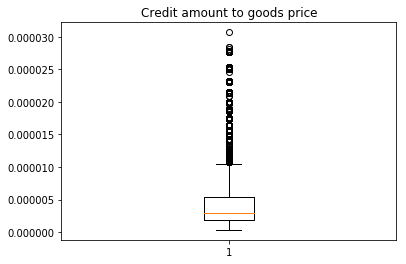

In [20]:
non_zero_good_price = application_train[application_train['AMT_GOODS_PRICE'].isnull() == False]
credit_to_good_price = non_zero_good_price['AMT_CREDIT'] / non_zero_good_price['AMT_GOODS_PRICE']
plt.boxplot(credit_to_good_price);
plt.title('Credit amount to goods price');

We can see that most of the loans have the amount which is similar to the goods price, but there are some outliers.

##### NAME_HOUSING_TYPE

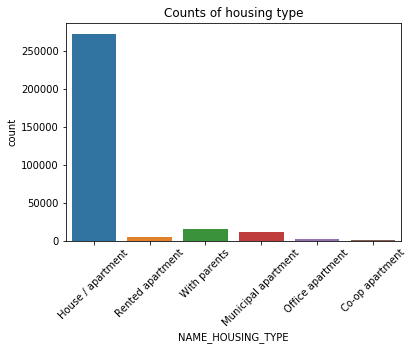

In [21]:
sns.countplot(application_train['NAME_HOUSING_TYPE']);
plt.xticks(rotation=45);
plt.title('Counts of housing type');

##### Contact information
There are 6 features showing that client provided some contact information. Let's see how many ways of contact clients usually provide.

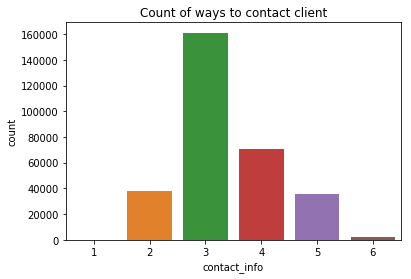

In [22]:
application_train['contact_info'] = application_train['FLAG_MOBIL'] + application_train['FLAG_EMP_PHONE'] + application_train['FLAG_WORK_PHONE'] + application_train['FLAG_CONT_MOBILE'] + application_train['FLAG_PHONE'] + application_train['FLAG_EMAIL']
sns.countplot(application_train['contact_info']);
plt.title('Count of ways to contact client');

Most clients provide 3 ways to contact them and usually miinimus is 2, if we don't consider several people who left only 1.

# deliquencies
It is very important to see how many times clients was late with payments or defaulted his or her loans. I suppose info about his or her social circle is also important. I'll divide values into 2 groups: 0,1 and more than 1. 

In [23]:
application_train.loc[application_train['OBS_30_CNT_SOCIAL_CIRCLE'] > 1, 'OBS_30_CNT_SOCIAL_CIRCLE'] = '1+'
application_train.loc[application_train['DEF_30_CNT_SOCIAL_CIRCLE'] > 1, 'DEF_30_CNT_SOCIAL_CIRCLE'] = '1+'
application_train.loc[application_train['OBS_60_CNT_SOCIAL_CIRCLE'] > 1, 'OBS_60_CNT_SOCIAL_CIRCLE'] = '1+'
application_train.loc[application_train['DEF_60_CNT_SOCIAL_CIRCLE'] > 1, 'DEF_60_CNT_SOCIAL_CIRCLE'] = '1+'

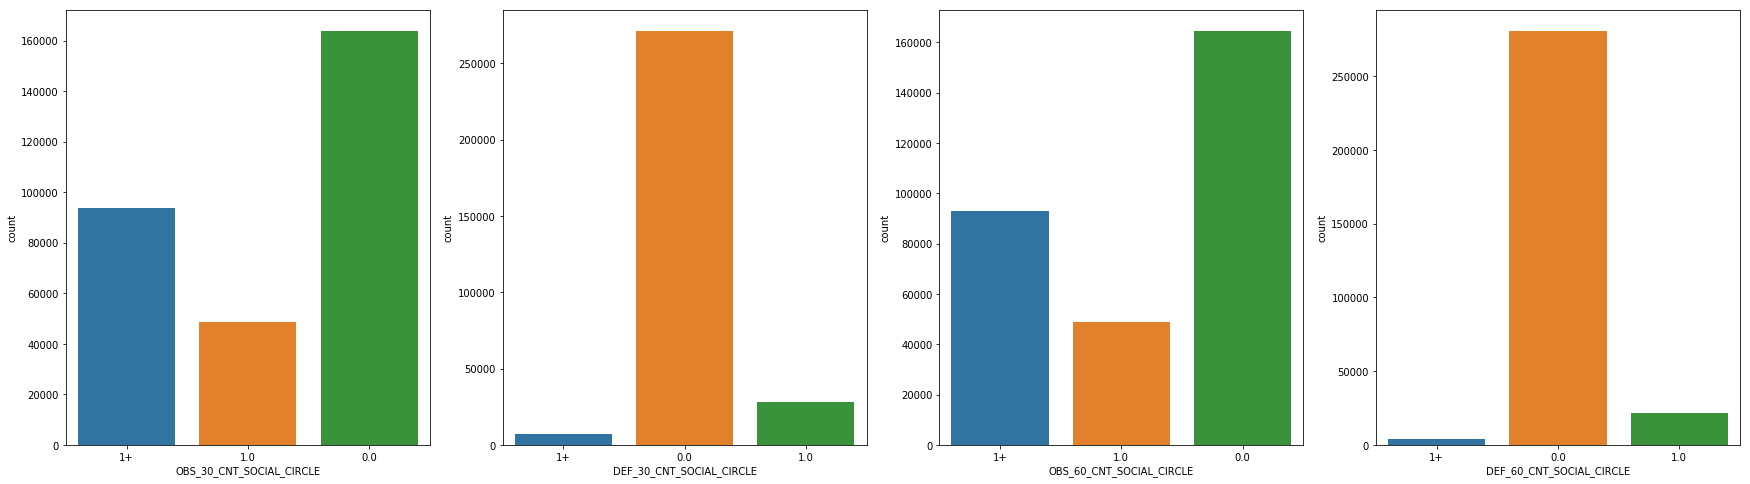

In [24]:
fig, ax = plt.subplots(figsize=(30,8))
plt.subplot(1,4,1)
sns.countplot(application_train['OBS_30_CNT_SOCIAL_CIRCLE']);
plt.subplot(1,4,2)
sns.countplot(application_train['DEF_30_CNT_SOCIAL_CIRCLE']);
plt.subplot(1,4,3)
sns.countplot(application_train['OBS_60_CNT_SOCIAL_CIRCLE']);
plt.subplot(1,4,4)
sns.countplot(application_train['DEF_60_CNT_SOCIAL_CIRCLE']);

#### Continuous variables

##### AMT_INCOME_TOTAL

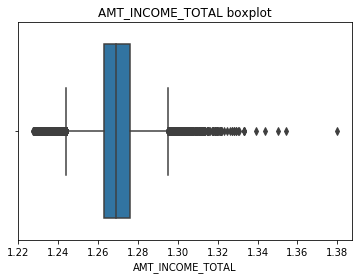

In [25]:
sns.boxplot(application_train['AMT_INCOME_TOTAL']);
plt.title('AMT_INCOME_TOTAL boxplot');

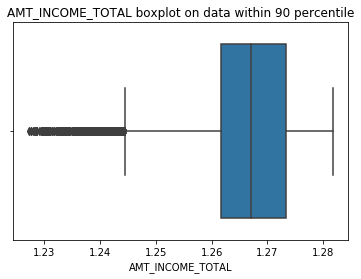

In [26]:
sns.boxplot(application_train[application_train['AMT_INCOME_TOTAL'] < np.percentile(application_train['AMT_INCOME_TOTAL'], 90)]['AMT_INCOME_TOTAL']);
plt.title('AMT_INCOME_TOTAL boxplot on data within 90 percentile');

In [27]:
application_train.groupby('TARGET').agg({'AMT_INCOME_TOTAL': ['mean', 'median', 'count']})

AMT_INCOME_TOTAL                  
                   mean    median   count
TARGET                                   
0              1.268981  1.269163  282686
1              1.268285  1.267078   24825

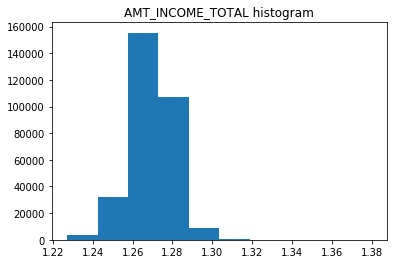

In [28]:
plt.hist(application_train['AMT_INCOME_TOTAL']);
plt.title('AMT_INCOME_TOTAL histogram');

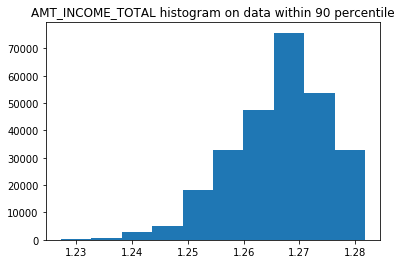

In [29]:
plt.hist(application_train[application_train['AMT_INCOME_TOTAL'] < np.percentile(application_train['AMT_INCOME_TOTAL'], 90)]['AMT_INCOME_TOTAL']);
plt.title('AMT_INCOME_TOTAL histogram on data within 90 percentile');

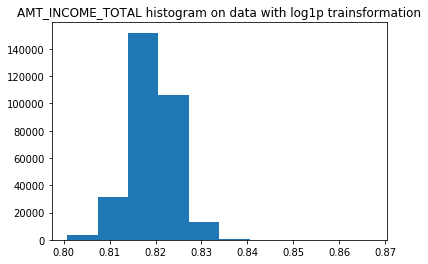

In [30]:
plt.hist(np.log1p(application_train['AMT_INCOME_TOTAL']));
plt.title('AMT_INCOME_TOTAL histogram on data with log1p trainsformation');

We can see following things from the information above:
- Income feature has some huge outliers. This could be due to rich individuals or due to errors in data.
- Average income is almost similar for those who repay the loans and those who don't.
- If we leave only data within 90 percentile, it is almost normally distributed.
- Log transformation also helps.

##### AMT_CREDIT

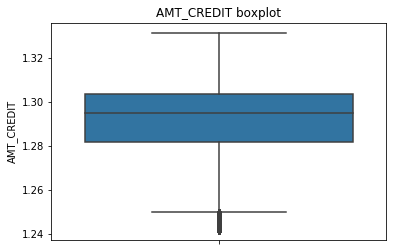

In [31]:
sns.boxplot(application_train['AMT_CREDIT'], orient='v');
plt.title('AMT_CREDIT boxplot');

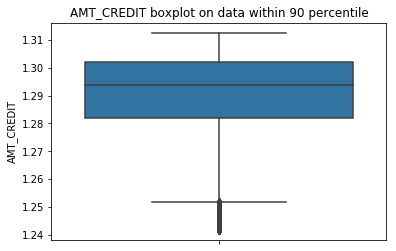

In [32]:
sns.boxplot(application_train[application_train['AMT_CREDIT'] < np.percentile(application_train['AMT_CREDIT'], 95)]['AMT_CREDIT'], orient='v');
plt.title('AMT_CREDIT boxplot on data within 90 percentile');

In [33]:
application_train.groupby('TARGET').agg({'AMT_CREDIT': ['mean', 'median', 'count']})

AMT_CREDIT                  
             mean    median   count
TARGET                             
0        1.292679  1.294791  282686
1        1.292153  1.294017   24825

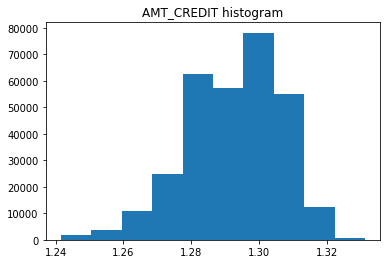

In [34]:
plt.hist(application_train['AMT_CREDIT']);
plt.title('AMT_CREDIT histogram');

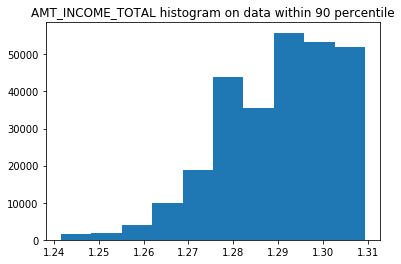

In [35]:
plt.hist(application_train[application_train['AMT_CREDIT'] < np.percentile(application_train['AMT_CREDIT'], 90)]['AMT_CREDIT']);
plt.title('AMT_INCOME_TOTAL histogram on data within 90 percentile');

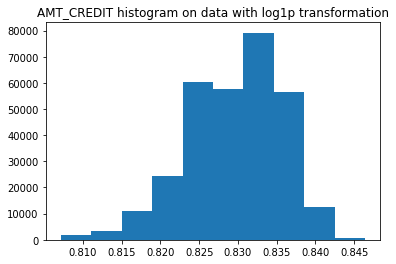

In [36]:
plt.hist(np.log1p(application_train['AMT_CREDIT']));
plt.title('AMT_CREDIT histogram on data with log1p transformation');

This feature shows the amount of the loan in question.
We can see following things from the information above:
- income feature has some outliers. Maybe mortgage?;
- average credit amoint is almost similar for those who repay the loans and those who don't;
- if we leave only data within 95 percentile, it is almost normally distributed;
- log transformation also helps;

##### DAYS_BIRTH

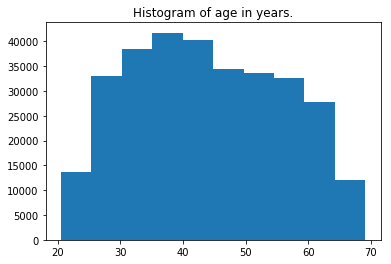

In [37]:
application_train['age'] = application_train['DAYS_BIRTH'] / -365
plt.hist(application_train['age']);
plt.title('Histogram of age in years.');

We can see that age distribution is almost normal and most of the people are between 30 and 40 years.

##### DAYS_EMPLOYED

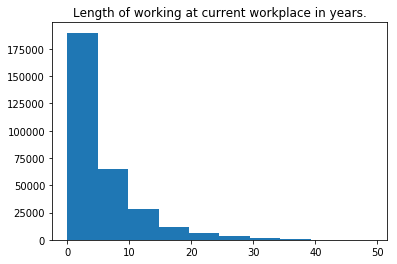

In [38]:
application_train.loc[application_train['DAYS_EMPLOYED'] == 365243, 'DAYS_EMPLOYED'] = 0
application_train['years_employed'] = application_train['DAYS_EMPLOYED'] / -365
plt.hist(application_train['years_employed']);
plt.title('Length of working at current workplace in years.');

Ther was a strange value - 365243, it could mean empty values or some errors, so I replace it with zero.
A lot of people don't work, but let's look deeper into this.

In [39]:
application_train.groupby(['NAME_INCOME_TYPE']).agg({'years_employed': ['mean', 'median', 'count', 'max'], 'age': ['median']})

years_employed                                     age
                               mean    median   count        max     median
NAME_INCOME_TYPE                                                           
Businessman                7.874795  6.280822      10  14.917808  47.498630
Commercial associate       5.833627  4.147945   71617  48.071233  39.780822
Maternity leave            7.224110  8.273973       5  10.306849  39.350685
Pensioner                  0.002448 -0.000000   55362  35.246575  60.413699
State servant              9.454441  7.205479   21703  48.172603  40.693151
Student                    6.835160  5.069863      18  21.931507  36.663014
Unemployed                 0.000000 -0.000000      22  -0.000000  45.860274
Working                    6.446909  4.427397  158774  49.073973  39.876712

Well, it seems that a lot of non-working people are pensioners, which is normal. As for working people - they seem to work for several years at one place.

Ther are so many features and so many possible angles from which we can analyze them. Let's see this for example:

In [40]:
application_train.groupby(['NAME_EDUCATION_TYPE', 'NAME_INCOME_TYPE']).agg({'AMT_INCOME_TOTAL': ['mean', 'median', 'count', 'max']})

AMT_INCOME_TOTAL            \
                                                               mean    median   
NAME_EDUCATION_TYPE           NAME_INCOME_TYPE                                  
Academic degree               Commercial associate         1.279121  1.280012   
                              Pensioner                    1.271909  1.270190   
                              State servant                1.277769  1.278029   
                              Working                      1.275148  1.275814   
Higher education              Businessman                  1.292214  1.293830   
                              Commercial associate         1.276411  1.275814   
                              Maternity leave              1.270899  1.267078   
                              Pensioner                    1.268984  1.269163   
                              State servant                1.273604  1.273312   
                              Student                      1.275009  1.272763   
                              Unemployed                   1.270375  1.272553   
                              Working                      1.272146  1.272603   
Incomplete higher             Commercial associate         1.273560  1.273312   
                              Pensioner                    1.266282  1.267078   
                              State servant                1.270340  1.270441   
                              Student                      1.270441  1.270441   
                              Unemployed                   1.257656  1.249655   
                              Working                      1.269823  1.270441   
Lower secondary               Commercial associate         1.269070  1.268492   
                              Pensioner                    1.258955  1.257980   
                              State servant                1.265225  1.264330   
                              Working                      1.265568  1.267078   
Secondary / secondary special Commercial associate         1.271039  1.270441   
                              Maternity leave              1.247567  1.247567   
                              Pensioner                    1.263486  1.263033   
                              State servant                1.268108  1.267078   
                              Student                      1.266460  1.268492   
                              Unemployed                   1.248830  1.249655   
                              Working                      1.267496  1.267078   

                                                                      
                                                     count       max  
NAME_EDUCATION_TYPE           NAME_INCOME_TYPE                        
Academic degree               Commercial associate      43  1.305230  
                              Pensioner                 26  1.301768  
                              State servant             23  1.305230  
                              Working                   72  1.298553  
Higher education              Businessman               10  1.321480  
                              Commercial associate   24025  1.350023  
                              Maternity leave            3  1.287640  
                              Pensioner               8188  1.321480  
                              State servant           8863  1.327146  
                              Student                    6  1.296388  
                              Unemployed                 6  1.286345  
                              Working                33762  1.343899  
Incomplete higher             Commercial associate    3400  1.321480  
                              Pensioner                518  1.295602  
                              State servant            770  1.295602  
                              Student                    1  1.270441  
                              Unemployed                 3  1.281808  
                              Working 

We can see that most of the loans are taken by working people with secondary education.

## Transforming and merging data

In [5]:
application_train['AMT_INCOME_TOTAL'] = np.log1p(application_train['AMT_INCOME_TOTAL'])
application_train['AMT_CREDIT'] = np.log1p(application_train['AMT_CREDIT'])
application_train['OWN_CAR_AGE'] = application_train['OWN_CAR_AGE'].fillna(0)
application_train['app AMT_CREDIT / AMT_ANNUITY'] = application_train['AMT_CREDIT'] / application_train['AMT_ANNUITY']
application_train['app EXT_SOURCE mean'] = application_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
application_train['app EXT_SOURCE_1 / DAYS_BIRTH'] = application_train['EXT_SOURCE_1'] / application_train['DAYS_BIRTH']
application_train['app AMT_INCOME_TOTAL / 12- AMT_ANNUITY'] = application_train['AMT_INCOME_TOTAL'] / 12. - application_train['AMT_ANNUITY']
application_train['app AMT_INCOME_TOTAL / AMT_ANNUITY'] = application_train['AMT_INCOME_TOTAL'] /  application_train['AMT_ANNUITY']
application_train['app AMT_INCOME_TOTAL -  AMT_GOODS_PRICE'] =  application_train['AMT_INCOME_TOTAL'] - application_train['AMT_GOODS_PRICE']

In [6]:
application_test.loc[application_test['OBS_30_CNT_SOCIAL_CIRCLE'] > 1, 'OBS_30_CNT_SOCIAL_CIRCLE'] = '1+'
application_test.loc[application_test['DEF_30_CNT_SOCIAL_CIRCLE'] > 1, 'DEF_30_CNT_SOCIAL_CIRCLE'] = '1+'
application_test.loc[application_test['OBS_60_CNT_SOCIAL_CIRCLE'] > 1, 'OBS_60_CNT_SOCIAL_CIRCLE'] = '1+'
application_test.loc[application_test['DEF_60_CNT_SOCIAL_CIRCLE'] > 1, 'DEF_60_CNT_SOCIAL_CIRCLE'] = '1+'
np.log1p(application_test['AMT_INCOME_TOTAL'])
np.log1p(application_test['AMT_CREDIT'])
application_test['age'] = application_test['DAYS_BIRTH'] / -365
application_test.loc[application_test['DAYS_EMPLOYED'] == 365243, 'DAYS_EMPLOYED'] = 0
application_test['years_employed'] = application_test['DAYS_EMPLOYED'] / -365
application_test['AMT_INCOME_TOTAL'] = np.log1p(application_test['AMT_INCOME_TOTAL'])
application_test['AMT_CREDIT'] = np.log1p(application_test['AMT_CREDIT'])
application_test['OWN_CAR_AGE'] = application_test['OWN_CAR_AGE'].fillna(0)
application_test['app AMT_CREDIT / AMT_ANNUITY'] = application_test['AMT_CREDIT'] / application_test['AMT_ANNUITY']
application_test['app EXT_SOURCE mean'] = application_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
application_test['app EXT_SOURCE_1 / DAYS_BIRTH'] = application_test['EXT_SOURCE_1'] / application_test['DAYS_BIRTH']
application_test['app AMT_INCOME_TOTAL / 12 - AMT_ANNUITY'] = application_test['AMT_INCOME_TOTAL'] / 12. - application_test['AMT_ANNUITY']
application_test['app AMT_INCOME_TOTAL / AMT_ANNUITY'] = application_test['AMT_INCOME_TOTAL'] / application_test['AMT_ANNUITY']
application_test['app AMT_INCOME_TOTAL - AMT_GOODS_PRICE'] = application_test['AMT_INCOME_TOTAL'] - application_test['AMT_GOODS_PRICE']

In [41]:
for col in ['FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'WEEKDAY_APPR_PROCESS_START']:
    unique_values = list(set(list(application_train[col].astype(str).unique()) + list(application_test[col].astype(str).unique())))
    le.fit(unique_values)
    application_train[col] = le.transform(application_train[col].astype(str))
    application_test[col] = le.transform(application_test[col].astype(str))

In [42]:
train = application_train

In [43]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,app AMT_CREDIT / AMT_ANNUITY,app EXT_SOURCE mean,app EXT_SOURCE_1 / DAYS_BIRTH,app AMT_INCOME_TOTAL / 12- AMT_ANNUITY,app AMT_INCOME_TOTAL / AMT_ANNUITY,app AMT_INCOME_TOTAL - AMT_GOODS_PRICE,contact_info,age,years_employed
0,100002,1,0,1,0,1,0,1.275814,1.290061,24700.5,351000.0,6,7,4,3,1,0.018801,-9461,-637,-3648.0,-2120,0.0,1,1,0,1,1,0,8,1.0,2,2,6,10,0,0,0,0,0,0,5,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,3,0,0.0149,5,0,1,1,1,1,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.000052,0.161787,-0.000009,-24700.393682,0.000052,-3.509987e+05,4,25.920548,1.745205
1,100003,0,0,0,0,0,0,1.281808,1.311812,35698.5,1129500.0,1,4,1,1,1,0.003541,-16765,-1188,-1186.0,-291,0.0,1,1,0,1,1,0,3,2.0,1,1,1,11,0,0,0,0,0,0,39,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,3,0,0.0714,0,0,2,0,2,0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000037,0.466757,-0.000019,-35698.393183,0.000036,-1.129499e+06,4,45.931507,3.254795
2,100004,0,1,1,1,1,0,1.251290,1.267078,6750.0,135000.0,6,7,4,3,1,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,8,1.0,2,2,1,9,0,0,0,0,0,0,11,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [44]:
test = application_test

In [45]:
train = train.fillna(0)
test = test.fillna(0)

In [48]:
X = train.drop(['SK_ID_CURR', 'contact_info', 'TARGET'], axis = 1)
y = train['TARGET']
X_test = test.drop(['SK_ID_CURR'], axis = 1)

## Basic Modelling ; LightGBM

In [49]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 42)
params = {
    'boosting' : 'dart',
    'application' : 'binary',
    'learning_rate' : 0.01,
    'num_leaves' : 34,
    'max_depth' : 5,
    'feature_fraction' : 0.9,
    'scale_pos_weight' : 2, 
    'reg_alpha' : 0.05,
    'reg_lambda' : 0.1
}

model = lgb.train(params, lgb.Dataset(X_train, y_train), 1000, [lgb.Dataset(X_train, y_train), lgb.Dataset(X_valid, y_valid)], verbose_eval=10, early_stopping_rounds=20)

Training until validation scores don't improve for 20 rounds.
[10]	valid_0's binary_logloss: 0.274301	valid_1's binary_logloss: 0.273474
[20]	valid_0's binary_logloss: 0.270184	valid_1's binary_logloss: 0.269421
[30]	valid_0's binary_logloss: 0.26787	valid_1's binary_logloss: 0.267181
[40]	valid_0's binary_logloss: 0.266702	valid_1's binary_logloss: 0.266064
[50]	valid_0's binary_logloss: 0.275548	valid_1's binary_logloss: 0.275047
[60]	valid_0's binary_logloss: 0.293041	valid_1's binary_logloss: 0.292684
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.266341	valid_1's binary_logloss: 0.265731


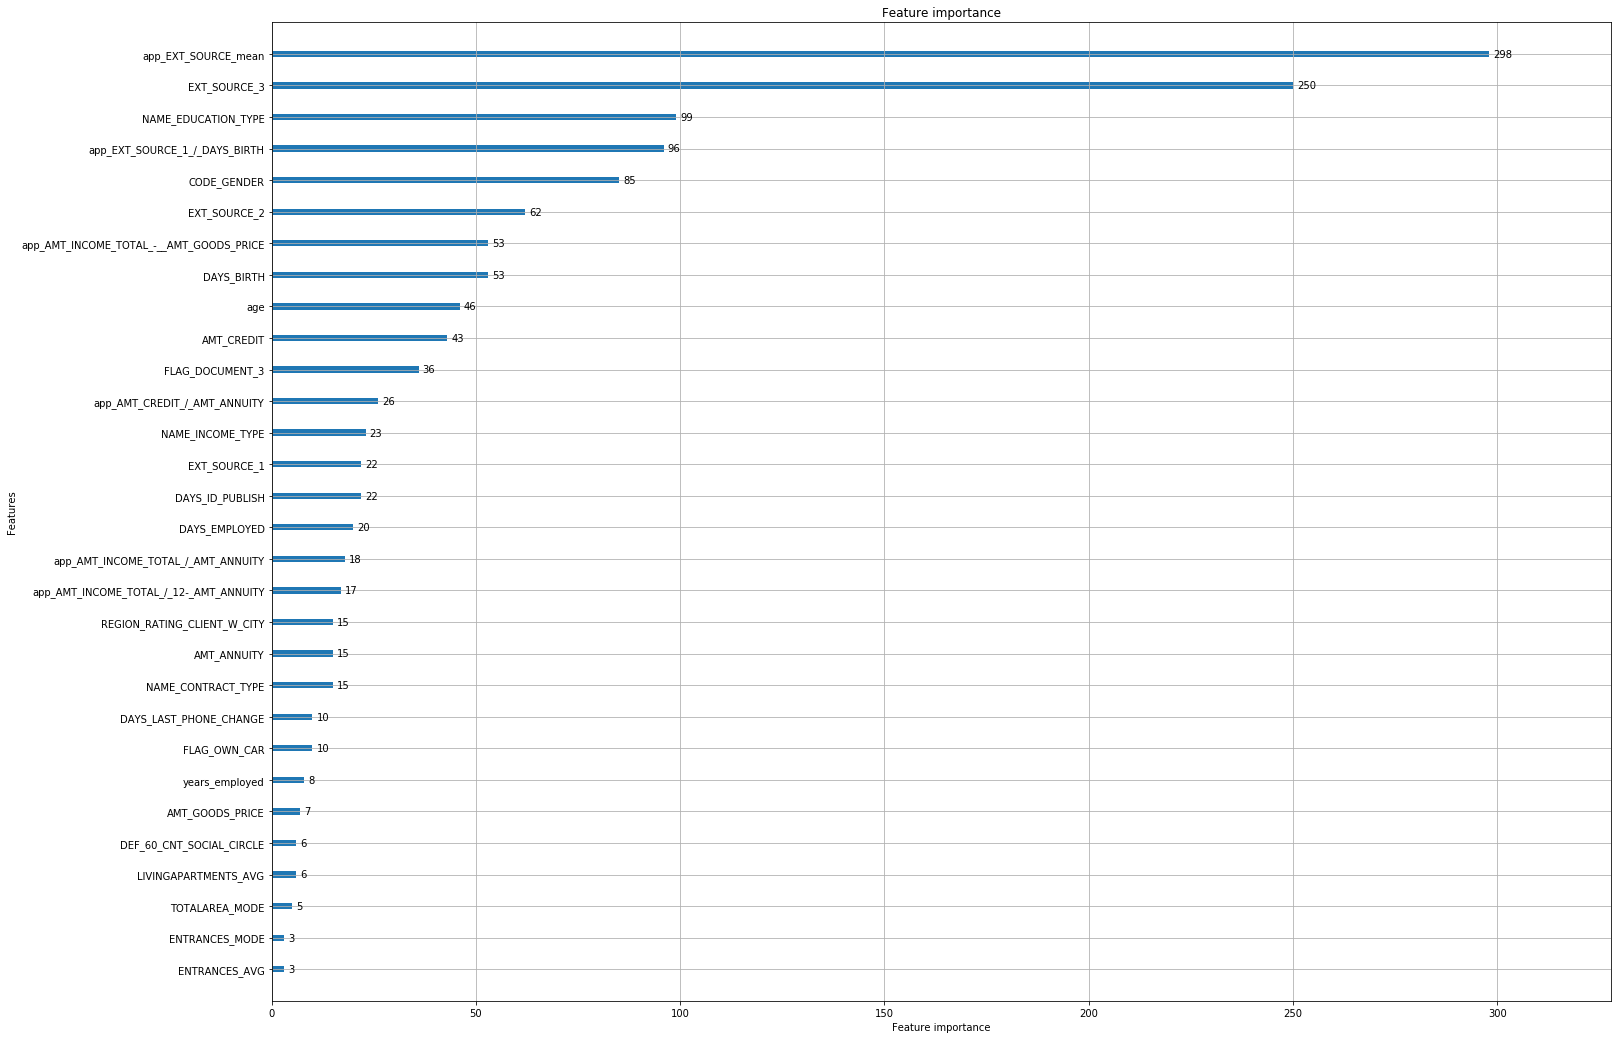

In [51]:
lgb.plot_importance(model, max_num_features=30, figsize=(24,18));

In [54]:
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
params={
    'colsample_bytree' : 0.8,
    'learning_rate' : 0.01,
    'num_leaves' : 34,
    'subsample' : 0.97,
    'max_depth' : 8,
    'reg_alpha' : 0.03,
    'reg_lambda' : 0.07,
    'min_split_gain' : 0.01,
    'min_child_weight' : 38
}

prediction = np.zeros(X_test.shape[0])
for n_folds, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    train_x, train_y = X.iloc[train_idx], y.iloc[train_idx]
    valid_x, valid_y = X.iloc[valid_idx], y.iloc[valid_idx]
    clf = lgb.LGBMClassifier(**params)
    clf.fit(train_x, train_y, eval_set = [(train_x, train_y), (valid_x, valid_y)], eval_metric = 'auc', verbose = 100, early_stopping_rounds = 50) 
    prediction += clf.predict(X_test)

Training until validation scores don't improve for 50 rounds.
[100]	training's auc: 0.74582	valid_1's auc: 0.740801
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.74582	valid_1's auc: 0.740801
Training until validation scores don't improve for 50 rounds.
[100]	training's auc: 0.746502	valid_1's auc: 0.730469
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.746502	valid_1's auc: 0.730469
Training until validation scores don't improve for 50 rounds.
[100]	training's auc: 0.746026	valid_1's auc: 0.739705
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.746026	valid_1's auc: 0.739705
Training until validation scores don't improve for 50 rounds.
[100]	training's auc: 0.745776	valid_1's auc: 0.739269
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.745776	valid_1's auc: 0.739269
Training until validation scores don't improve for 50 rounds.
[100]	training's auc: 0.745321	valid_1's auc: 0.738925
Did n

In [55]:
sub = test[['SK_ID_CURR']].copy()
sub['TARGET'] = prediction / 10
sub.to_csv('sub.csv', index = False)

This was EDA and basic feature engineering I know that feature engineering and modelling could be much better, but decided to make EDA the main focus of this kernel. I'll do better feature engineering and modellin in the next one.